# Validating Simulation Grids via Maxwell's Equations

In [59]:
from mu2e.datafileprod import DataFileMaker
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
df_GA05= DataFileMaker('../datafiles/FieldMapsGA05/DSMap',use_pickle = True).data_frame
df_Mau10 = DataFileMaker('../datafiles/Mau10/Standard_Maps/Mu2e_DSMap',use_pickle = True).data_frame

In [16]:
df_Mau10_selection = df_Mau10.query('5000<Z<13000 and -800<=X<=800 and -800<=Y<=800')[['X','Y','Z','Bx','By','Bz']]
df_GA05_selection = df_GA05.query('5000<Z<13000 and -800<=X<=800 and -800<=Y<=800')[['X','Y','Z','Bx','By','Bz']]
df_combo = pd.merge(df_Mau10_selection,df_GA05_selection,on=['X','Y','Z'],suffixes=('m','g'))
df_combo.sort_values(['X','Y','Z'],inplace=True)

For our first pass, we are going to calculate the divergence of the magnetic field.  We are going to do so by using using the Divergence Theorem,
$$\iiint_V(\nabla \cdot F)\ dV = \bigcirc \!\!\!\!\!\!\!\!\iint_S (F\cdot \mathbf{n})\ dS,$$
where we calculate the surface integral around some volume of the normal components of the magnetic field.  In our case, it makes logical sense to calculate the surface integral over a cubic surface.  Using the simulation grid, in which Bx,By,Bz triplets are given in 25mm spacings, we will create 3x3x3 cubes.  The central node on each face will represent the field vector for that face, and thus the total flux is the sum of all 6 faces (properly accounting for the direction of the normal).

We can accomplish this by creating 3D numpy arrays, and using vectorization in an intelligent manner.  We will label each cube by its central node.  We can then compare the total flux for each cube in the two simulations (Mau10 and GA05) that we are considering.  In principle, the flux should be 0 for all cubes; there are no magnetic monopoles (as far as we know).  In practice, the total flux will be non-zero, due to numeric errors.

In [21]:
xs = df_combo.X.unique()
ys = df_combo.Y.unique()
zs = df_combo.Z.unique()

bxs_Mau10 = df_combo.Bxm.reshape(len(xs),len(ys),len(zs))
bys_Mau10 = df_combo.Bym.reshape(len(xs),len(ys),len(zs))
bzs_Mau10 = df_combo.Bzm.reshape(len(xs),len(ys),len(zs))

bxs_GA05 = df_combo.Bxg.reshape(len(xs),len(ys),len(zs))
bys_GA05 = df_combo.Byg.reshape(len(xs),len(ys),len(zs))
bzs_GA05 = df_combo.Bzg.reshape(len(xs),len(ys),len(zs))

In [26]:
div_Mau10 = bxs_Mau10[:-2,1:-1,1:-1] - bxs_Mau10[2:,1:-1,1:-1]\
+ bys_Mau10[1:-1,:-2,1:-1] - bys_Mau10[1:-1,2:,1:-1]\
+ bzs_Mau10[1:-1,1:-1,:-2] - bzs_Mau10[1:-1,1:-1,2:]

div_GA05 = bxs_GA05[:-2,1:-1,1:-1] - bxs_GA05[2:,1:-1,1:-1]\
+ bys_GA05[1:-1,:-2,1:-1] - bys_GA05[1:-1,2:,1:-1]\
+ bzs_GA05[1:-1,1:-1,:-2] - bzs_GA05[1:-1,1:-1,2:]

In [27]:
cube_centers = []
for x in xs[1:-1]:
    for y in ys[1:-1]:
        for z in zs[1:-1]:
            cube_centers.append('x{0}_y{1}_z{2}'.format(x,y,z))

In [30]:
df_maxwell = pd.DataFrame({'div_Mau10':div_Mau10.flatten(),'div_GA05':div_GA05.flatten()}, index=cube_centers)
df_maxwell.head()

,div_GA05,div_Mau10
x-775.0_y-775.0_z5046.0,-0.015313,0.011888
x-775.0_y-775.0_z5071.0,0.175162,0.125476
x-775.0_y-775.0_z5096.0,-0.003900,0.022776
x-775.0_y-775.0_z5121.0,-0.009194,0.006493
x-775.0_y-775.0_z5146.0,-0.006052,0.002323


In [31]:
df_maxwell['abs_resid'] = np.abs(df_maxwell.div_GA05)-np.abs(df_maxwell.div_Mau10)

In [39]:
df_maxwell[df_maxwell.abs_resid>0.5]

,div_GA05,div_Mau10,abs_resid
x-750.0_y-775.0_z6071.0,0.521625,0.019276,0.502348
x-750.0_y-750.0_z6746.0,0.556482,-0.047767,0.508715
x-725.0_y-775.0_z6746.0,0.605746,-0.059710,0.546037
x750.0_y-750.0_z5046.0,0.592871,0.086131,0.506739
x750.0_y750.0_z6396.0,0.549660,0.038235,0.511425


In [42]:
df_maxwell[df_maxwell.abs_resid<-0.2]

,div_GA05,div_Mau10,abs_resid
x-775.0_y-775.0_z6771.0,-0.052673,-0.269560,-0.216887
x-775.0_y-775.0_z7596.0,0.059875,-0.269102,-0.209227
x-775.0_y775.0_z7596.0,-0.034144,-0.269102,-0.234958
x700.0_y-775.0_z7596.0,0.035457,0.286212,-0.250755
x725.0_y-750.0_z7596.0,-0.038056,0.254187,-0.216131
x725.0_y750.0_z7596.0,0.002155,0.254187,-0.252032
x750.0_y-725.0_z7596.0,0.021341,0.260098,-0.238758
x750.0_y725.0_z7596.0,-0.022170,0.260098,-0.237928
x775.0_y700.0_z7596.0,0.082060,0.287337,-0.205277


In [45]:
sort(np.abs(df_maxwell.div_Mau10.unique()))

array([  0.00000000e+00,   2.77555756e-17,   1.11022302e-16, ...,
         2.87486305e-01,   2.87827237e-01,   2.88037285e-01])

In [46]:
sort(np.abs(df_maxwell.div_GA05.unique()))

array([  0.00000000e+00,   1.11022302e-16,   1.11022302e-16, ...,
         5.69262628e-01,   5.92870890e-01,   6.05746240e-01])

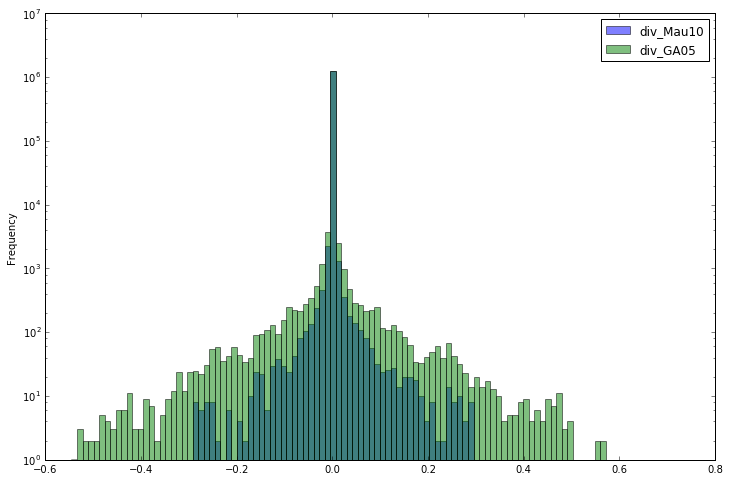

In [60]:
df_maxwell[['div_Mau10','div_GA05']].plot.hist(alpha=0.5, bins=100, logy=True)

The total calculated flux through our cubes is much greater on average for the GA05 than the Mau10 simulation.  However, we cannot yet infer whether or not this due to a failure to adhere to Maxwell's equations, or simply due to numerical inaccuracy stemming from larger gradients.